# Predicting online shoppers’ purchasing intention
## Classification using SHAP for feature interpretation and selection
Models tested
* Logistic Regression
* Decision Tree
* Random Forest
* Extra Trees
* AdaBoost
* Gradient Boosting
* XGBoost

**Goal: Understand model predictions and improve model performance using SHAPley values to subset features by importance**

---

Data source:
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

SHAP:
https://shap.readthedocs.io/en/latest/index.html


In [1]:
# download from github
%%capture
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/X_test.npy;
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/X_train.npy;
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/y_test.npy;
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/y_train.npy;

## to view curr directory
# !ls
!pip install shap


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pprint
import warnings
from collections import Counter

# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, TransformerMixin
# from imblearn.over_sampling import SMOTE  # try for imbalanced classes
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

# metrics
from sklearn.metrics import accuracy_score, auc, roc_auc_score, classification_report

from google.colab import files

In [3]:
import shap
shap.initjs()

In [4]:
feature_names2 = ['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay',
 'Month_Aug',
 'Month_Dec',
 'Month_Feb',
 'Month_Jul',
 'Month_June',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sep',
 'VisitorType_New_Visitor',
 'VisitorType_Other',
 'VisitorType_Returning_Visitor',
 'Weekend_True',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType']

print(len(feature_names2))

28


In [5]:
## Load arrays to reload for later use
## Load cleaned data arrays
with open('X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open('X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
with open('y_test.npy', 'rb') as f:
    y_test = np.load(f)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13972, 28) (4069, 28) (13972,) (4069,)


In [6]:
X_train = pd.DataFrame(X_train, columns=feature_names2)
X_test = pd.DataFrame(X_test, columns=feature_names2)


# Tuning Hyperparameters

### Random Forest Classifier 
with randomized grid search for tuning hyperparams and finding optimal model

In [7]:
rfc = RandomForestClassifier()
# what possible params to tune
# pprint.pprint(rfc.get_params())

In [8]:
# specify parameters and distributions to sample from
param_dist = {
    "n_estimators": list(np.linspace(200, 1600, 8, dtype=int)),
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Random search of parameters, using cross validation, use all cores
rf_rand = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=0, n_jobs=-1)

In [9]:
# Fit the random search model
rf_rand.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 47.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [10]:
# print results of rand grid search - model before shap
best_params = rf_rand.best_params_
pprint.pprint(best_params)

{'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200}


In [11]:
## Random Forest new (optimized from results of grid search)

# best_params = {'n_estimators': 600,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'auto'}

# rfc = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=0)
rfc = RandomForestClassifier(**best_params)

rfc.fit(X_train,y_train)  # fit the model to the training data

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
## Get CV score
score = cross_val_score(rfc, X_train, y_train)
print(np.round(score.mean(), 4))

0.9201


In [25]:
## Calc Prec, Recall, F1 scores on test set

y_pred = rfc.predict(X_test)  # predict on test set
target_names = ['0: No Revenue', '1: Revenue']
report1 = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
print(report1)
report1_df = pd.DataFrame(report1).transpose()
model_name = "RandomForestClassifier"
report1_df.to_csv(f"{model_name}_report1.csv", index=False)
files.download(f"{model_name}_report1.csv")

{'0: No Revenue': {'precision': 0.9469106178764247, 'recall': 0.9188009313154831, 'f1-score': 0.9326440177252584, 'support': 3436}, '1: Revenue': {'precision': 0.6204081632653061, 'recall': 0.7203791469194313, 'f1-score': 0.6666666666666667, 'support': 633}, 'accuracy': 0.887933153108872, 'macro avg': {'precision': 0.7836593905708654, 'recall': 0.8195900391174572, 'f1-score': 0.7996553421959626, 'support': 4069}, 'weighted avg': {'precision': 0.8961177808725324, 'recall': 0.887933153108872, 'f1-score': 0.8912668579267603, 'support': 4069}}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
print(round(roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]),4))

0.9253


## SHAP visuals 

To show feature contributions to the model output (magnitude, postiive or negative class, num of samples, ...)


Types of plots
* Force Plot
* Bar Plot
* Beeswarm Plot / Scatter Plot
* Waterfall Plot (for indiv preds)

In [27]:
## Take smaller samples for visualization
X_train_sample = shap.utils.sample(X_train, nsamples=50, random_state=0)
X_test_sample = shap.utils.sample(X_test, nsamples=50, random_state=0)

## Kernel Explainer

In [28]:
# explain predictions of model on test set
explainer = shap.KernelExplainer(rfc.predict_proba, X_train_sample)

# compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

In [29]:
# Force Plot
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_sample)

Force plot:
    
* The horizontal/X-axis at the top represents the sample number. We have 100 samples in this visual.
* The two colors represent the two class labels (default or no default)

## Tree Explainer

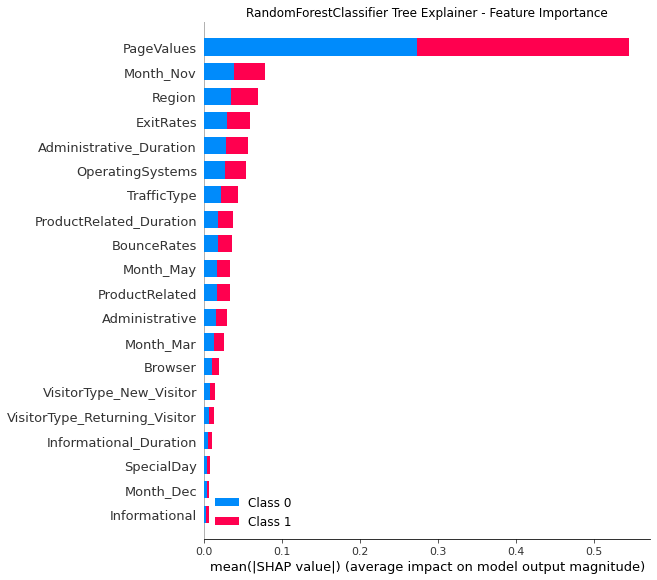

In [18]:
## Bar Plot 
# explain all the predictions in the test set
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test_sample)
plt.title(f"{model_name} Tree Explainer - Feature Importance")
shap.summary_plot(shap_values, (X_test_sample))

Bar Plot:

creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

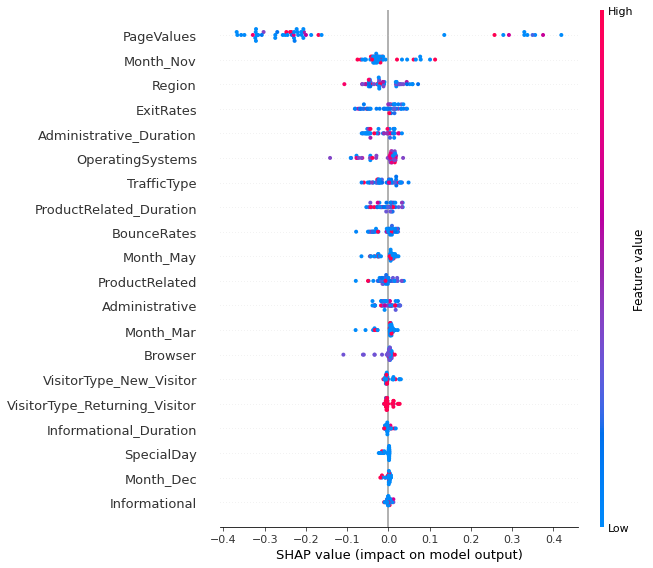

In [19]:
# index [1] represents class label 1
shap.summary_plot(shap_values[1], X_train_sample)

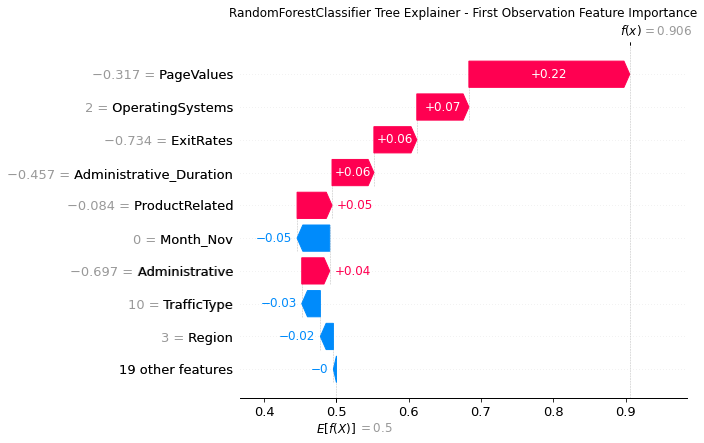

In [20]:
# Waterfall plot
# ## Designed for INDIVIDUAL preds
# shap.plots.waterfall(shap_values[0])
plt.title(f"{model_name} Tree Explainer - First Observation Feature Importance")
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], X_train_sample.iloc[0])

shap_values is a list of 2 arrays, representing class labels 0 and 1.

Both arrays have 50 observations and 29 features.

## Get the most and least important features

In [30]:
## Get mean of all training sample shap values
## Then get TOP 20 Features

## shap_value is a list of 2 np arrays
# print(shap_values[0].shape). ## this is training sample

train_shap_avg = np.average(shap_values[0], axis=0)
# print(train_shap_avg.shape)
train_shap_avg_2 = []
for i, val in enumerate(list(train_shap_avg)):
  train_shap_avg_2.append((i, feature_names2[i], val))

sorted_shap = sorted(train_shap_avg_2, key=lambda x: x[2])
top_20 = sorted_shap[:20]
top_20_indices = [t[0] for t in top_20]
to_keep = top_20_indices

In [31]:
print(len(to_keep))  ## keep this many features
print(to_keep)  ## column indicies of features to keep

20
[10, 19, 11, 13, 21, 5, 22, 12, 23, 20, 18, 4, 14, 2, 9, 3, 15, 25, 16, 27]


## New Model from Subset of Features

In [32]:
## Subset of training data using top N most important features from SHAP
X_train_ss = X_train.iloc[:,to_keep]
X_train_ss.shape

(13972, 20)

In [33]:
## Try RF, tune HPs, check CV score, check F1 score to compare with original

# specify parameters and distributions to sample from
param_dist = {
    "n_estimators": list(np.linspace(200, 1600, 8, dtype=int)),
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Random search of parameters, using cross validation, use all cores
rf_rand = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=0, n_jobs=-1)

# Fit the random search model
rf_rand.fit(X_train_ss, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 38.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [34]:
# print results of rand grid search
best_params2 = rf_rand.best_params_
pprint.pprint(best_params2)

{'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1600}


In [35]:
## Random Forest new (optimized from results of grid search) with Shap subselected features
rfc = RandomForestClassifier(**best_params2)
rfc.fit(X_train_ss, y_train)  # fit the model to the training data

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
## Random Forest new (OLD hps) with Shap subselected features
rfc_old = RandomForestClassifier(**best_params)
rfc_old.fit(X_train_ss, y_train)  # fit the model to the training data

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
## Get CV score
score = cross_val_score(rfc, X_train_ss, y_train)
print("With new hyperparams:", np.round(score.mean(), 4))

score2 = cross_val_score(rfc_old, X_train_ss, y_train)
print("With old hyperparams:", np.round(score2.mean(), 4))

With new hyperparams: 0.8203
With old hyperparams: 0.8183


Old hps did better than new - use rfc_old for final report of RF

In [40]:
## Random Forest New with tuned hps from Shap subselection

## Calc Prec, Recall, F1 scores on test set
X_test_ss = X_test.iloc[:,to_keep]
# y_pred = rfc.predict(X_test_ss)  # predict on test set
y_pred = rfc_old.predict(X_test_ss)  # predict on test set
target_names = ['0: No Revenue', '1: Revenue']
report2 = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
print(report2)
report2_df = pd.DataFrame(report2).transpose()
# model_name = str(rfc).strip('()')
report2_df.to_csv(f"{model_name}_report2.csv", index=False)
files.download(f"{model_name}_report2.csv")

{'0: No Revenue': {'precision': 0.8781991982732038, 'recall': 0.8288707799767171, 'f1-score': 0.8528222787842492, 'support': 3436}, '1: Revenue': {'precision': 0.288135593220339, 'recall': 0.37598736176935227, 'f1-score': 0.32625085675119947, 'support': 633}, 'accuracy': 0.758417301548292, 'macro avg': {'precision': 0.5831673957467713, 'recall': 0.6024290708730347, 'f1-score': 0.5895365677677243, 'support': 4069}, 'weighted avg': {'precision': 0.786405081291522, 'recall': 0.758417301548292, 'f1-score': 0.7709054171113762, 'support': 4069}}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
print(round(roc_auc_score(y_test, rfc.predict_proba(X_test_ss)[:,1]),4))
print(round(roc_auc_score(y_test, rfc_old.predict_proba(X_test_ss)[:,1]),4))

0.7225
0.7201


### Results

Models tested in this notebook:
1. Random Forest with original data (after cleaning, encoding) and tuned hps 
2. Random Forest with Shap subselected data and newly tuned hps
3. Random Forest with Shap subselected data and old tuned hps from model (1)

---


TODO: Compare Prec, Recall, F1, AUC scores for these 3 models for RF

TODO: Compare with DAC feature engineered model for RF. Compare with other types of models.